In [1]:
# Set the display width to max
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
# Import Libraries
import keras
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from IPython.display import FileLink, FileLinks
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import pylab
from scipy.stats.stats import pearsonr
%matplotlib inline

Using TensorFlow backend.



AllHits/NormalizedCharge
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500989 entries, 0 to 500988
Columns: 406 entries, pixel_78 to pixel_148
dtypes: float64(405), int32(1)
memory usage: 1.5 GB
None

AllHits/NormalizedCharge
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7735 entries, 887 to 500794
Columns: 407 entries, Pixel_number to pixel_148
dtypes: float64(405), int32(1), int64(1)
memory usage: 24.0 MB
None

Test Data Shape:  (3867, 407)
Train Data Shape:  (3868, 407)
Train on 3481 samples, validate on 387 samples
Epoch 1/100
3481/3481 [==============================] - 13s 4ms/step - loss: 0.5575 - acc: 0.7170 - val_loss: 0.4969 - val_acc: 0.7649
Epoch 2/100
3481/3481 [==============================] - 12s 3ms/step - loss: 0.5018 - acc: 0.7463 - val_loss: 0.4454 - val_acc: 0.7700
Epoch 3/100
3481/3481 [==============================] - 11s 3ms/step - loss: 0.4528 - acc: 0.7794 - val_loss: 0.4074 - val_acc: 0.8243
Epoch 4/100
3481/3481 [==============================] - 1

Epoch 16/100
3481/3481 [==============================] - 15s 4ms/step - loss: 0.1342 - acc: 0.9480 - val_loss: 0.1979 - val_acc: 0.9199
Epoch 17/100
3481/3481 [==============================] - 15s 4ms/step - loss: 0.1246 - acc: 0.9535 - val_loss: 0.1945 - val_acc: 0.9406
Epoch 18/100
3481/3481 [==============================] - 15s 4ms/step - loss: 0.1150 - acc: 0.9555 - val_loss: 0.2523 - val_acc: 0.9173
Epoch 19/100
3481/3481 [==============================] - 15s 4ms/step - loss: 0.1145 - acc: 0.9546 - val_loss: 0.2306 - val_acc: 0.9147
Epoch 20/100
3481/3481 [==============================] - 15s 4ms/step - loss: 0.1121 - acc: 0.9586 - val_loss: 0.1927 - val_acc: 0.9354
Epoch 21/100
3481/3481 [==============================] - 15s 4ms/step - loss: 0.1080 - acc: 0.9589 - val_loss: 0.1818 - val_acc: 0.9483
Epoch 22/100
3481/3481 [==============================] - 15s 4ms/step - loss: 0.0966 - acc: 0.9612 - val_loss: 0.2004 - val_acc: 0.9354
Epoch 23/100
3481/3481 [=================

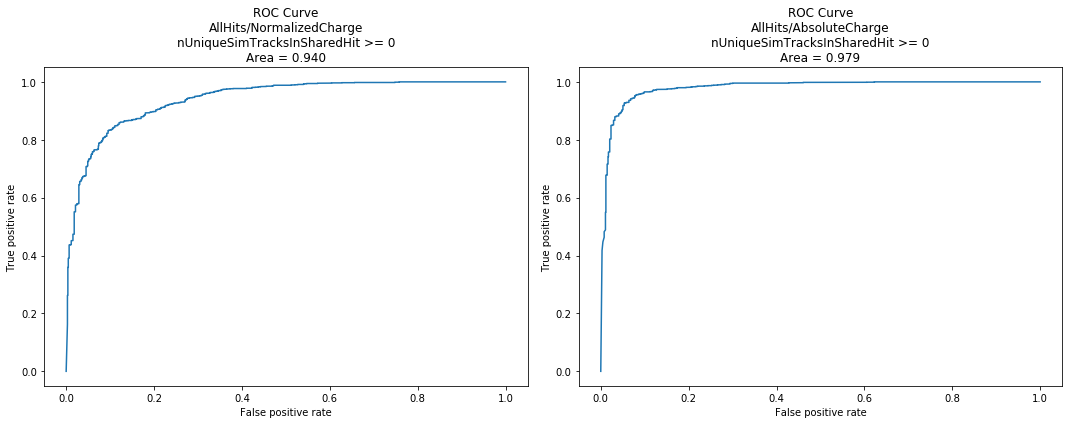

In [2]:
### Loop over 2 data categories and generate the ROC curve for each ###

# File paths
datafilenames = ["SharedHits/NormalizedCharge/output_final_1.h5","SharedHits/AbsoluteCharge/output_final_1.h5",
                "Shared100NonShared/NormalizedCharge/output_final_1.h5","Shared100NonShared/AbsoluteCharge/output_final_1.h5",
                "AllHits/NormalizedCharge/output_final_1.h5","AllHits/AbsoluteCharge/output_final_1.h5"]

# Initiate figure
fig = plt.figure()

# One image has 20x20 pixels = 400 pixels 
pixels = ["pixel_{0}".format(i) for i in range(20*20)]
def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,20,20), axis=-1)

# Loop over the data files
for counter,datafilename in enumerate(datafilenames[4:6]):
    
    # Import the data
    df = pd.read_hdf("/uscms_data/d3/bbonham/TrackingDstar/LambaAnalyzer/output_of_postprocess/"+datafilename, key="df", mode='r', start=0, stop=500989)
    
    # Setup different cuts for different data
    if counter == 0 or counter == 1: # Shared Hits
        cuttitle = "nUniqueSimTracksInSharedHit >= 0"
        stringforcut = "(df['nUniqueSimTracksInSharedHit']>=0)"
    if counter == 2 or counter == 3: # Shared100NonShared Hits
        cuttitle = "nUniqueSimTracksInSharedHit != (0|1)"
        stringforcut = '(df["nUniqueSimTracksInSharedHit"]!=0) & (df["nUniqueSimTracksInSharedHit"]!=1)'
    if counter == 4 or counter == 5: # All Hits
        cuttitle = "nUniqueSimTracksInSharedHit != (0|1)"
        stringforcut = '(df["nUniqueSimTracksInSharedHit"]!=0) & (df["nUniqueSimTracksInSharedHit"]!=1)'
    
    # Print info on dataframe
    print ""
    print '\033[1m' + datafilename[:-18] + '\033[0m' # name printed in bold
    print df.info()
    print ""
    
    # Data set before final cuts
    df_old = df
    df_old_train=df.sample(frac=0.5)
    df_old_test=df.drop(df_old_train.index)
    images_old_train = to_image(df_old_train)
    images_old_test = to_image(df_old_test)
    
    # Compute the pixel_number variable
    pixelColumns = ["pixel_%i" % x for x in range(400)]
    pixels_df = df[pixelColumns].values
    pixel_number = pixels_df.astype(bool).sum(axis=1)
    df.insert(0, "Pixel_number", pixel_number)
    
    # Make final cuts
    df = df[(df["Pixel_number"]>1) & (df["GenDeltaR"]<0.1) & eval(stringforcut)]
    
    # Print info on dataframe
    print '\033[1m' + datafilename[:-18] + '\033[0m' # name printed in bold
    print df.info()
    print ""
    
    # frac=0.5 sets half training and half testing
    df_train=df.sample(frac=0.5)
    df_test=df.drop(df_train.index)
    images_train = to_image(df_train)
    images_test = to_image(df_test)
    
    # Sanity check: printout (events, variables) Variables include 36 pixels, and a few others you can find using df.info() command
    print "Test Data Shape: ",df_test.shape
    print "Train Data Shape: ",df_train.shape
    #print df.info()
    
    ### CNN ###
    # Define the network
    model = keras.models.Sequential()
    # layer (1) you can play with these layers individually or together until you find the best combination
    model.add(keras.layers.Conv2D(32, kernel_size=(8,8), padding='same', activation='relu',input_shape=(20,20,1),data_format = "channels_last"))
    model.add(keras.layers.Conv2D(32, kernel_size=(4,4), padding='same', activation='relu')) 
    # layer (2)
    model.add(keras.layers.Flatten(input_shape=(20,20,1))) # 20,20
    # layer 2.5, dropout 10%
    model.add(Dropout(0.1))
    # layer (3)
    model.add(keras.layers.Dense(100, activation='relu'))
    #layer (4)
    model.add(keras.layers.Dense(2, activation='softmax'))
    # Layer (5), train the network
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"]) 
    # epochs: number of times you run the CNN.
    epochs_number = 100 # change the number of epochs used in the training HERE
    # early stopping callback: stops training early to prevent overtraining
    early_stopping = EarlyStopping(monitor='val_loss', patience=10) 
    # model checkpoint callback: this saves our model architecture + parameters into dense_model.h5
    model_checkpoint = ModelCheckpoint('CNN_model.h5', monitor='val_loss', 
                                       save_best_only=True, 
                                       save_weights_only=False, mode='auto', 
                                       period=1)
    
    ### Train the classifier ###
    history = model.fit(images_train,
                        keras.utils.to_categorical(df_train["nUniqueSimTracksInSharedHit"]>1), 
                        epochs = epochs_number, 
                        callbacks=[early_stopping, model_checkpoint], 
                        validation_split=0.1) # validation split is fraction of training sample used for testing (here 10%)
    #os.remove("CNN_model.h5") # after use, delete model_checkpoint
    
    ### Add ROC curve subplot to main plot ###
    # Setup
    ret = model.predict(images_test)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(keras.utils.to_categorical(df_test["nUniqueSimTracksInSharedHit"]>1)[:,1], ret[:,1])
    from sklearn.metrics import auc
    auc_keras = auc(fpr_keras, tpr_keras)
    auc = np.trapz(tpr_keras,fpr_keras)
    
    # Add subplot
    ax = fig.add_subplot(1,2,counter+1)
    ax.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc))
    ax.set_title("ROC Curve"+"\n"+datafilename[:-18]+"\n"+cuttitle+"\n"+"Area = {:.3f}".format(auc))
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')

# Plot & Save
fig.set_size_inches(15, 6)
fig.tight_layout()
plt.savefig("ROC_Curves_Final_AllHits.png")
plt.show()